<img src="https://5264302.fs1.hubspotusercontent-na1.net/hubfs/5264302/Demo%20Asset%20Resources/Demo%20Covers/CM-Demo-eth_staking_metrics-Cover.png" width=1100 margin-left='auto' margin-right='auto'/>

## Resources
This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client and Network Data Pro.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Knowledge Base](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.

### Notebook Setup

In [133]:
from os import environ
import pandas as pd
import numpy as np
import seaborn as sns
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import logging
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [134]:
# Chart themes
sns.set_theme()
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,9)})
sns.set_style("whitegrid",{'axes.grid' : True,'grid.linestyle': '--', 'grid.color': 'gray','axes.edgecolor': 'white',})

In [135]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [136]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")
client = CoinMetricsClient(api_key)

2024-10-09 15:07:36 INFO     Using API key found in environment


# Calculate Validator Yield and Yield Inclusive of Priority Fees

Using ETH Execution Layer and ETH Consensus Layer APR metrics, we can extract the total yield awarded to validators as well as break down how that yield is issued, whether it is from priority fees paid to include a transaction earlier in a block or from Ethereum's issuance formula. In combination with historical data on priority fees, we can estimate what a validator should expect to earn. Note that maximal extractable value (MEV) is another source of revenue for validators but is currently not considered as part of this analysis.

We assume to begin calculating metrics on the day Ethereum migrated from Proof-of-Work to Proof-of-Stake, colloquially known as "The Merge" on September 15, 2022, as this is when validators began to receive both native issuance as well as priority fees.

In [137]:
start = '2022-09-15'

In [138]:
validator_yield = client.get_asset_metrics(
    assets='eth_cl',
    metrics=['ValidatorAPRNominal'],
    start_time = start,
).to_dataframe()

In [139]:
validator_yield['time'] = pd.to_datetime(validator_yield['time'])
validator_yield

,asset,time,ValidatorAPRNominal
0,eth_cl,2022-09-15 00:00:00+00:00,4.266465
1,eth_cl,2022-09-16 00:00:00+00:00,4.244164
2,eth_cl,2022-09-17 00:00:00+00:00,4.283294
3,eth_cl,2022-09-18 00:00:00+00:00,4.309157
4,eth_cl,2022-09-19 00:00:00+00:00,4.316741
...,...,...,...
750,eth_cl,2024-10-04 00:00:00+00:00,2.786609
751,eth_cl,2024-10-05 00:00:00+00:00,2.786805
752,eth_cl,2024-10-06 00:00:00+00:00,2.785373
753,eth_cl,2024-10-07 00:00:00+00:00,2.787284


In [140]:
total_stake_yield = client.get_asset_metrics(
    assets='eth',
    metrics=['ValidatorAPRNominal'],
    start_time = start,
).to_dataframe()

In [141]:
total_stake_yield['time'] = pd.to_datetime(total_stake_yield['time'])
total_stake_yield

,asset,time,ValidatorAPRNominal
0,eth,2022-09-15 00:00:00+00:00,15.302587
1,eth,2022-09-16 00:00:00+00:00,5.661437
2,eth,2022-09-17 00:00:00+00:00,5.284938
3,eth,2022-09-18 00:00:00+00:00,5.527239
4,eth,2022-09-19 00:00:00+00:00,5.716192
...,...,...,...
750,eth,2024-10-04 00:00:00+00:00,3.182258
751,eth,2024-10-05 00:00:00+00:00,3.244051
752,eth,2024-10-06 00:00:00+00:00,3.354408
753,eth,2024-10-07 00:00:00+00:00,3.543015


# Combine Data and Solve for Priority Fees

Subtracting ETH_CL's "ValidatorAPRNominal" from ETH "ValidatorAPRNominal" removes validator rewards to solve for Priority Fees. Separating Validator and Priority Fees for charting can better visually project from which source validators can expect rewards.

In [142]:
# Convert the 'ValidatorAPRNominal' column to float (if necessary)
validator_yield['ValidatorAPRNominal'] = validator_yield['ValidatorAPRNominal'].astype(float)
total_stake_yield['ValidatorAPRNominal'] = total_stake_yield['ValidatorAPRNominal'].astype(float)

# Merge the DataFrame to create a simplified table to work from
priority_fee_yield = validator_yield.merge(total_stake_yield, how='left', on='time', sort=True, suffixes=('_validator', '_total'))
priority_fee_yield

,asset_validator,time,ValidatorAPRNominal_validator,asset_total,ValidatorAPRNominal_total
0,eth_cl,2022-09-15 00:00:00+00:00,4.266465,eth,15.302587
1,eth_cl,2022-09-16 00:00:00+00:00,4.244164,eth,5.661437
2,eth_cl,2022-09-17 00:00:00+00:00,4.283294,eth,5.284938
3,eth_cl,2022-09-18 00:00:00+00:00,4.309157,eth,5.527239
4,eth_cl,2022-09-19 00:00:00+00:00,4.316741,eth,5.716192
...,...,...,...,...,...
750,eth_cl,2024-10-04 00:00:00+00:00,2.786609,eth,3.182258
751,eth_cl,2024-10-05 00:00:00+00:00,2.786805,eth,3.244051
752,eth_cl,2024-10-06 00:00:00+00:00,2.785373,eth,3.354408
753,eth_cl,2024-10-07 00:00:00+00:00,2.787284,eth,3.543015


In [143]:
# Using the updated DataFrame, subtract one column from the other to get the "Priority Fee Yield"
priority_fee_yield['Priority Fee Yield'] = priority_fee_yield['ValidatorAPRNominal_total']-priority_fee_yield['ValidatorAPRNominal_validator']
# Output the DataFrame
print(priority_fee_yield)

    asset_validator                      time  ValidatorAPRNominal_validator  \
0            eth_cl 2022-09-15 00:00:00+00:00                       4.266465   
1            eth_cl 2022-09-16 00:00:00+00:00                       4.244164   
2            eth_cl 2022-09-17 00:00:00+00:00                       4.283294   
3            eth_cl 2022-09-18 00:00:00+00:00                       4.309157   
4            eth_cl 2022-09-19 00:00:00+00:00                       4.316741   
..              ...                       ...                            ...   
750          eth_cl 2024-10-04 00:00:00+00:00                       2.786609   
751          eth_cl 2024-10-05 00:00:00+00:00                       2.786805   
752          eth_cl 2024-10-06 00:00:00+00:00                       2.785373   
753          eth_cl 2024-10-07 00:00:00+00:00                       2.787284   
754          eth_cl 2024-10-08 00:00:00+00:00                       2.787763   

    asset_total  ValidatorAPRNominal_to

In [144]:
# Using the above DataFrame, set the DataFrame to the requested columns to prepare to chart
priority_fee_yield = priority_fee_yield[["time","ValidatorAPRNominal_validator","Priority Fee Yield"]]
priority_fee_yield = priority_fee_yield.rename({"ValidatorAPRNominal_validator": "ValidatorAPRNominal"}, axis=1)
priority_fee_yield

,time,ValidatorAPRNominal,Priority Fee Yield
0,2022-09-15 00:00:00+00:00,4.266465,11.036122
1,2022-09-16 00:00:00+00:00,4.244164,1.417272
2,2022-09-17 00:00:00+00:00,4.283294,1.001644
3,2022-09-18 00:00:00+00:00,4.309157,1.218082
4,2022-09-19 00:00:00+00:00,4.316741,1.399451
...,...,...,...
750,2024-10-04 00:00:00+00:00,2.786609,0.395649
751,2024-10-05 00:00:00+00:00,2.786805,0.457246
752,2024-10-06 00:00:00+00:00,2.785373,0.569035
753,2024-10-07 00:00:00+00:00,2.787284,0.755730


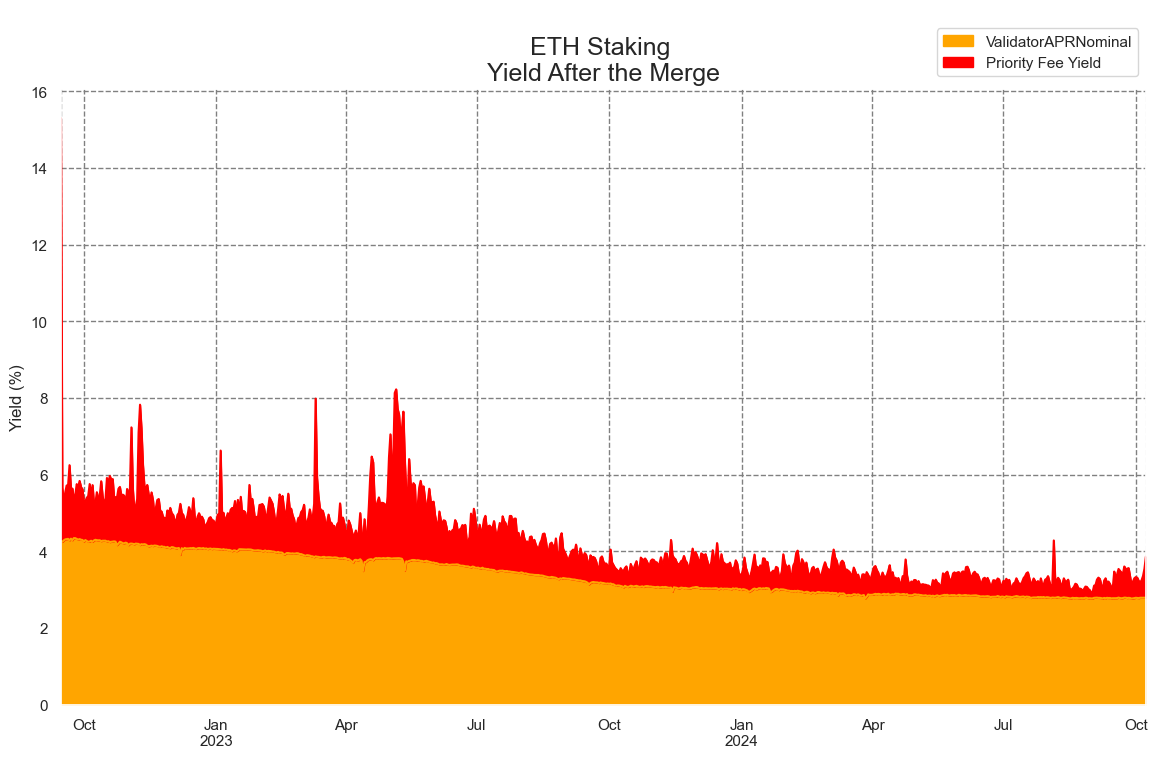

In [145]:
ax = priority_fee_yield.plot(x="time", y=["ValidatorAPRNominal","Priority Fee Yield"], kind="area", color=["orange", "red"], figsize=(14, 8))
ax.set_ylabel('Yield (%)')
ax.set_xlabel('')
ax.set_title('\nETH Staking \nYield After the Merge', fontsize=18)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.11))
plt.show()

# Calculate ETH Supply: Staked vs. Unstaked

One of the many advantages of a blockchain-based ledger is auditability, but increasingly complex consensus architectures and supply mechanics can make it difficult to understand the full picture of asset supply. Ethereum's shift to proof-of-stake introduced a number of novel considerations in obtaining network-wide supply figures. In the following example, we combine various Supply metrics from ETH's Consensus and Execution Layers to ascertain the total amount of staked vs. unstaked supply.

In [146]:
start = '2022-01-01'

### Consensus Layer Metrics

In [147]:
cl_supply = client.get_asset_metrics(
    assets='eth_cl',
    metrics=['SplyCur','SplyStkedNtv'],
    start_time = start,
    frequency = '1d'
).to_dataframe()

cl_supply = cl_supply.rename(columns={"SplyCur": "SplyCur_CL"})

### Execution Layer Metrics

In [148]:
el_supply = client.get_asset_metrics(
    assets='eth',
    metrics=['SplyCur','SplyCLCont'],
    start_time = start,
    frequency = '1d'
).to_dataframe()

el_supply = el_supply.rename(columns={"SplyCur": "SplyCur_EL"})

In [149]:
adjusted_supply = cl_supply.merge(el_supply, on='time', how='inner')
adjusted_supply = adjusted_supply.set_index('time')

In [150]:
adjusted_supply = adjusted_supply[['SplyCur_EL','SplyCur_CL','SplyCLCont','SplyStkedNtv']]

### Calculate the total 'adjusted' ETH supply 

In [151]:
adjusted_supply['Total ETH Supply'] = adjusted_supply['SplyCur_EL'] + (adjusted_supply['SplyCur_CL'] - adjusted_supply['SplyCLCont'])

In [152]:
adjusted_supply['Staked Supply'] = adjusted_supply['SplyStkedNtv']

In [153]:
adjusted_supply['Unstaked Supply'] = adjusted_supply['Total ETH Supply'] - adjusted_supply['Staked Supply'] 

In [154]:
adjusted_supply

,SplyCur_EL,SplyCur_CL,SplyCLCont,SplyStkedNtv,Total ETH Supply,Staked Supply,Unstaked Supply
time,,,,,,,
2022-01-01 00:00:00+00:00,118049177.834937,9227820.793013,8852770.0,8828515,118424228.62795,8828515,109595713.62795
2022-01-02 00:00:00+00:00,118054804.893592,9242509.802432,8866898.0,8841891,118430416.696023,8841891,109588525.696023
2022-01-03 00:00:00+00:00,118060102.632049,9264680.84189,8887122.0,8862723,118437661.47394,8862723,109574938.47394
2022-01-04 00:00:00+00:00,118063057.343795,9286929.282994,8915506.0,8883635,118434480.626789,8883635,109550845.626789
2022-01-05 00:00:00+00:00,118064691.965118,9311811.478199,8931074.0,8907187,118445429.443318,8907187,109538242.443318
...,...,...,...,...,...,...,...
2024-10-04 00:00:00+00:00,120374548.840799,34825174.317181,51368824.455364,34517583,103830898.702616,34517583,69313315.702616
2024-10-05 00:00:00+00:00,120376085.966294,34873055.876068,51414791.455364,34501136,103834350.386997,34501136,69333214.386997
2024-10-06 00:00:00+00:00,120378389.065311,34850415.642479,51434953.455364,34493548,103793851.252426,34493548,69300303.252426


### Plot staked vs. unstaked supply

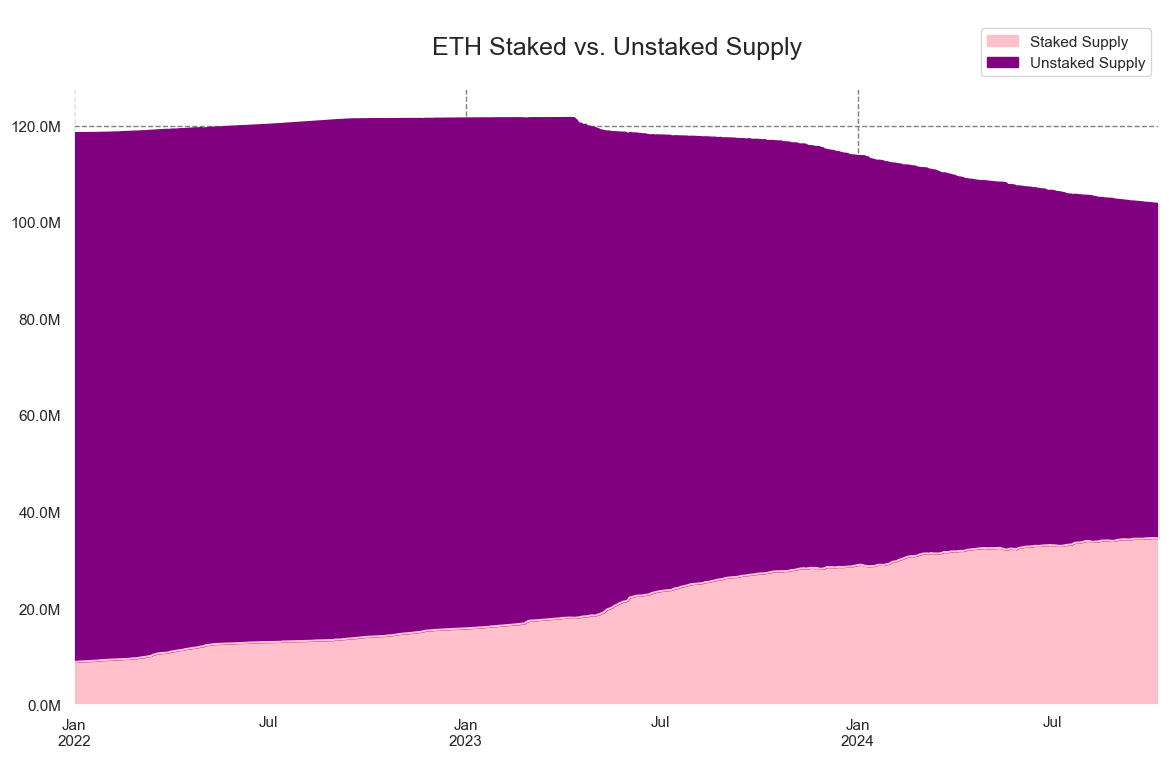

In [155]:
ax = adjusted_supply[['Staked Supply', 'Unstaked Supply']].plot.area(stacked=True, figsize=(14, 8),color=['pink', 'purple'])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('\nETH Staked vs. Unstaked Supply\n',fontsize=18)
ax.yaxis.set_major_formatter(lambda x, _: f'{x*1e-6}M')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.11))
plt.show()